In [1]:
cd ../Probing_framework/

/home/jovyan/Probing_framework


In [6]:
from transformers import MT5Model, T5Tokenizer
import pandas as pd
import torch
from tqdm import tqdm
from datasets import Dataset
import conllu
from sklearn.preprocessing import LabelEncoder
from datasets import DatasetDict


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [7]:
def get_dataset(filename):
    with open(filename) as file:
        text = file.read()

    sents = {"text":[], "tag":[]}
    for sent in conllu.parse(text):
        tokens, pos = list(zip(*[(token["form"], token["upos"]) for token in sent if token["upos"] != "_"]))
        sents["text"].append(" ".join(tokens))
        sents["tag"].append(" ".join(pos))

    dataset = Dataset.from_dict(sents)

    return dataset

def decode_tokens(example):
    idx = 1
    enc =[(x, tokenizer.encode(x, add_special_tokens=False)) for x in example.split()]

    desired_output = []

    for x, token in enc:
        tokenoutput = []
        for ids in token:
            tokenoutput.append(idx)
            idx +=1
        desired_output.append(tokenoutput)

    return desired_output


def parse_batch(batch, sentences, length=768):
    embedding_list = []
    tags = []
    for embedding, sentence, tag in zip(batch, sentences["text"], sentences["tag"]):
        tokens = decode_tokens(sentence)
        embeddings = torch.zeros(len(tokens), length)
        for num, token in enumerate(tokens):
            embeddings[num,:] = embedding[token[0]:token[-1]+1].mean(axis=0)
        embedding_list.append(embeddings)
        tags.extend([word for word in tag.split()])
    return torch.cat(embedding_list), tags


class VectorDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels):
        self.input_ids = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx: int):
        input_ids = self.input_ids[idx]
        labels = self.labels[idx]
        sample = (input_ids, labels)
        return sample
    
def get_vector_dataset(data_loader, check_labels=None):
    labels = []
    embeddings = []
    for sentence in tqdm(data_loader):
        enc = tokenizer(sentence["text"], padding=True, truncation=True,
                        return_tensors="pt")
        with torch.no_grad():
            enc = enc.to(device)

            model_outputs = model.encoder(
                input_ids=enc["input_ids"],
                attention_mask=enc["attention_mask"],
                return_dict=True,
            )

            model_outputs = (
                model_outputs["last_hidden_state"]
                if "last_hidden_state" in model_outputs
                else model_outputs["encoder_hidden_states"]
            )

            embs, tags = parse_batch(model_outputs.detach().cpu(), sentence)
            embeddings.append(embs)
            labels.extend(tags)
    
    if check_labels:
        checked_embeddings = []
        checked_labels = []
        for e, l in zip(embeddings, labels):
            if l in check_labels:
                checked_embeddings.append(e)
                checked_labels.append(l)
        return torch.cat(checked_embeddings), checked_labels
    return torch.cat(embeddings), labels

In [8]:
def form_final_dataloaders(
    tr_conllu_path,
    va_conllu_path,
    te_conllu_path
):
    train_dataset = get_dataset(tr_conllu_path)
    eval_dataset = get_dataset(va_conllu_path)
    test_dataset = get_dataset(te_conllu_path)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=4)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

    train_embs, train_labels = get_vector_dataset(train_loader)
    eval_embs, eval_labels = get_vector_dataset(eval_loader, train_labels)
    test_embs, test_labels = get_vector_dataset(test_loader, train_labels)

    encoder = LabelEncoder()

    labels = train_labels
    encoder.fit(labels)

    train_labels = encoder.transform(train_labels)
    train_data = VectorDataset(train_embs, train_labels)
    pos_train = torch.utils.data.DataLoader(train_data, batch_size=8)


    eval_labels = encoder.transform(eval_labels)
    eval_data = VectorDataset(eval_embs, eval_labels)
    pos_eval = torch.utils.data.DataLoader(eval_data, batch_size=8)


    test_labels = encoder.transform(test_labels)
    test_data = VectorDataset(test_embs, test_labels)
    pos_test = torch.utils.data.DataLoader(test_data, batch_size=8)

    dataset = DatasetDict({
        "tr": pos_train,
        "va": pos_eval,
        "te": pos_test,
    })

    encoder_labels_mapping = dict(
        zip(
            encoder.classes_,
            encoder.transform(encoder.classes_),
        )
    )
    return dataset, encoder_labels_mapping, 

In [9]:
file_paths = {
    "Arabic_Bambara": [
        "/home/jovyan/protasov/conllu_data/ar_padt-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/ar_padt-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/bm_crb-ud-test.conllu",
    ],
    "Armenian_Bambara": [
        #"/home/jovyan/protasov/conllu_data/hy_bsut-ud-train.conllu",
        #"/home/jovyan/protasov/conllu_data/hy_bsut-ud-dev.conllu",
        "/home/jovyan/katya/t5_ner/hyw_armtdp-ud-train.conllu",
        "/home/jovyan/katya/t5_ner/hyw_armtdp-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/bm_crb-ud-test.conllu",
    ],
    "Dutch_Bambara": [
        "/home/jovyan/protasov/conllu_data/nl_alpino-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/nl_alpino-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/bm_crb-ud-test.conllu",
    ],
    "Lithuanian_Bambara": [
        "/home/jovyan/protasov/conllu_data/lt_hse-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/lt_hse-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/bm_crb-ud-test.conllu",
    ],
    "Arabic_Bhojpuri": [
        "/home/jovyan/protasov/conllu_data/ar_padt-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/ar_padt-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/bho_bhtb-ud-test.conllu",
    ],
    "German_Bhojpuri": [
        "/home/jovyan/protasov/conllu_data/de_gsd-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/de_gsd-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/bho_bhtb-ud-test.conllu",
    ],
    "Hindi_Bhojpuri": [
        "/home/jovyan/protasov/conllu_data/hi_hdtb-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/hi_hdtb-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/bho_bhtb-ud-test.conllu",
    ],
    "Persian_Bhojpuri": [
        "/home/jovyan/protasov/conllu_data/fa_perdt-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/fa_perdt-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/bho_bhtb-ud-test.conllu",
    ],
    "Italian_Cantonese": [
        "/home/jovyan/katya/t5_ner/it_partut-ud-train.conllu",
        "/home/jovyan/katya/t5_ner/it_partut-ud-dev.conllu",
#         "/home/jovyan/protasov/conllu_data/it_isdt-ud-train.conllu",
#         "/home/jovyan/protasov/conllu_data/it_isdt-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/yue_hk-ud-test.conllu",
    ],
    "Polish_Cantonese": [
        "/home/jovyan/protasov/conllu_data/pl_pdb-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/pl_pdb-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/yue_hk-ud-test.conllu",
    ],
    "Russian_Cantonese": [
        "/home/jovyan/protasov/conllu_data/ru_taiga-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/ru_taiga-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/yue_hk-ud-test.conllu",
    ],
    "Slovene_Cantonese": [
        "/home/jovyan/protasov/conllu_data/sl_ssj-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/sl_ssj-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/yue_hk-ud-test.conllu",
    ],
    "Afrikaans_Coptic": [
        "/home/jovyan/protasov/conllu_data/af_afribooms-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/af_afribooms-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/cop_scriptorium-ud-test.conllu",
    ],
    "Danish_Coptic": [
        "/home/jovyan/protasov/conllu_data/da_ddt-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/da_ddt-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/cop_scriptorium-ud-test.conllu",
    ],
    "German_Coptic": [
        "/home/jovyan/protasov/conllu_data/de_gsd-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/de_gsd-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/cop_scriptorium-ud-test.conllu",
    ],
    "Irish_Coptic": [
        "/home/jovyan/protasov/conllu_data/ga_idt-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/ga_idt-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/cop_scriptorium-ud-test.conllu",
    ],
    "Faroese_Guarani": [
        "/home/jovyan/protasov/conllu_data/fo_farpahc-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/fo_farpahc-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/gun_thomas-ud-test.conllu",
    ],
    "French_Guarani": [
        #"/home/jovyan/protasov/conllu_data/fr_gsd-ud-train.conllu",
        #"/home/jovyan/protasov/conllu_data/fr_gsd-ud-dev.conllu",
        "/home/jovyan/katya/t5_ner/fr_rhapsodie-ud-train.conllu",
        "/home/jovyan/katya/t5_ner/fr_rhapsodie-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/gun_thomas-ud-test.conllu",
    ],
    "Irish_Guarani": [
        "/home/jovyan/protasov/conllu_data/ga_idt-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/ga_idt-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/gun_thomas-ud-test.conllu",
    ],
    "Slovak_Guarani": [
        "/home/jovyan/protasov/conllu_data/sk_snk-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/sk_snk-ud-dev.conllu",
        "/home/jovyan/protasov/conllu_data/gun_thomas-ud-test.conllu",
    ],
    "Chinese_Komi-Zyryan": [
        #"/home/jovyan/protasov/conllu_data/lzh_kyoto-ud-train.conllu",
        #"/home/jovyan/protasov/conllu_data/lzh_kyoto-ud-dev.conllu",
        "/home/jovyan/katya/t5_ner/zh_gsd-ud-train.conllu",
        "/home/jovyan/katya/t5_ner/zh_gsd-ud-dev.conllu",
        "/home/jovyan/katya/t5_ner/kpv_lattice-ud-test.conllu",
        #"/home/jovyan/protasov/conllu_data/kpv_ikdp-ud-test.conllu",
    ],
    "Estonian_Komi-Zyryan": [
        "/home/jovyan/protasov/conllu_data/et_edt-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/et_edt-ud-dev.conllu",
        "/home/jovyan/katya/t5_ner/kpv_lattice-ud-test.conllu",
        #"/home/jovyan/protasov/conllu_data/kpv_ikdp-ud-test.conllu",
    ],
    "Slovene_Komi-Zyryan": [
        "/home/jovyan/protasov/conllu_data/sl_ssj-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/sl_ssj-ud-dev.conllu",
        "/home/jovyan/katya/t5_ner/kpv_lattice-ud-test.conllu",
        #"/home/jovyan/protasov/conllu_data/kpv_ikdp-ud-test.conllu",
    ],
    "Urdu_Komi-Zyryan": [
        "/home/jovyan/protasov/conllu_data/ur_udtb-ud-train.conllu",
        "/home/jovyan/protasov/conllu_data/ur_udtb-ud-dev.conllu",
        "/home/jovyan/katya/t5_ner/kpv_lattice-ud-test.conllu",
        #"/home/jovyan/protasov/conllu_data/kpv_ikdp-ud-test.conllu",
    ],
    
}

In [10]:
import os
for f in file_paths:
    files = file_paths[f]
    for i in files:
        assert os.path.exists(i)

In [11]:
new_dict_langs = {
    "hr-langs": {},
    "lr-langs": {},
}

for pair, files in file_paths.items():
    hr, lr = pair.split("_")
    hr_files = files[:2]
    lr_files = files[2:3]
    
    new_dict_langs["hr-langs"][hr] = hr_files
    new_dict_langs["lr-langs"][lr] = lr_files

In [13]:
from probing.pipeline import ProbingPipeline
from probing.utils import clear_memory

device = "cuda:0"
model_name = "google/mt5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = MT5Model.from_pretrained(model_name).to(device)

processed_pairs = set()
for hr_lang in new_dict_langs["hr-langs"]:
    for lr_lang in new_dict_langs["lr-langs"]:
        lang_pair = f"{hr_lang}_{lr_lang}"

        tr_path, va_path, te_path = new_dict_langs["hr-langs"][hr_lang]+new_dict_langs["lr-langs"][lr_lang]
        dataset, encoder_labels_mapping = form_final_dataloaders(tr_path, va_path, te_path)

        for _ in range(3):
            clear_memory()

            experiment = ProbingPipeline(
                hf_model_name=model_name,
                device="cuda:0",
                metric_names=["f1", "accuracy"],
                encoding_batch_size=32,
                classifier_batch_size=32,
                aggregation_embeddings="last",
                probing_type="singlerun"

            )

            experiment.run(
                probe_task=lang_pair,
                probing_dataloaders=dataset,
                verbose=True,
                train_epochs=50,
            )
        processed_pairs.add(lang_pair)

Some weights of the model checkpoint at google/mt5-base were not used when initializing MT5Model: ['lm_head.weight']
- This IS expected if you are initializing MT5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MT5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 257/257 [00:03<00:00, 66.73it/s]
Some weights of the model checkpoint at google/mt5-base were not used when initializing MT5Model: ['lm_head.weight']
- This IS expected if you are initializing MT5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

Probing by layers:   0%|          | 0/12 [00:00<?, ?it/s]

Note that you provide 2D tensor, which means that you consider not layerwise probing, but rather an output from `last_hidden_state`


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Plot results

In [14]:
import pathlib
import json


pairs_check_res = {}
pairs_metrics_logs = {
}

log_paths = [
    "/home/jovyan/Probing_framework/probing_results_after_call/" #provide your logs
]

for p in log_paths:
    p_logs = list(pathlib.Path(p).glob("**/*.json"))
    
    for p_log in p_logs:
        f = open(str(p_log))
        f_json = json.load(f)
        
        lang_pair = f_json["params"]["probing_task"]
        if lang_pair not in pairs_check_res:
            pairs_check_res[lang_pair] = 0
        pairs_check_res[lang_pair] += 1
        
        if lang_pair not in pairs_metrics_logs:
            pairs_metrics_logs[lang_pair] = {"f1": [], "accuracy": []}
        pairs_metrics_logs[lang_pair]["f1"] += f_json["results"]["test_score"]["f1"]["0"]
        pairs_metrics_logs[lang_pair]["accuracy"] += f_json["results"]["test_score"]["accuracy"]["0"]

In [15]:
import numpy as np
import pandas as pd

aggr_df = {
    "HR": [],
    "LR": [],
    "f1_mean": [],
    "accuracy_mean": [],
    "f1_std": [],
    "accuracy_std": []
}

for pair in pairs_metrics_logs:
    hr, lr = pair.split("_")
    f1 = np.mean(pairs_metrics_logs[pair]["f1"])
    accuracy = np.mean(pairs_metrics_logs[pair]["accuracy"])
    
    aggr_df["HR"].append(hr)
    aggr_df["LR"].append(lr)
    aggr_df["f1_mean"].append(f1)
    aggr_df["accuracy_mean"].append(accuracy)
    aggr_df["f1_std"].append(np.std(pairs_metrics_logs[pair]["f1"]))
    aggr_df["accuracy_std"].append(np.std(pairs_metrics_logs[pair]["accuracy"]))

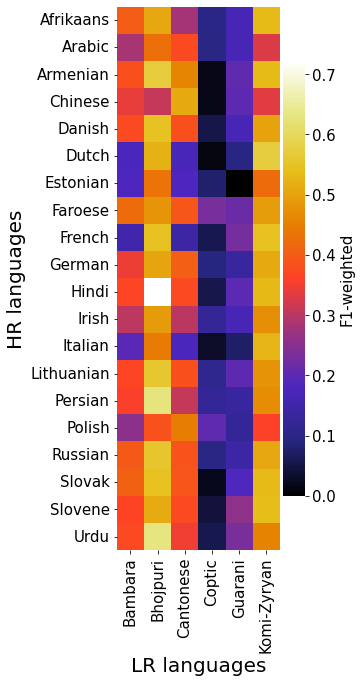

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(6,10))
table = pd.pivot_table(pd.DataFrame(aggr_df), index="HR", columns="LR", values="f1_mean")

sns.heatmap(
    table.fillna(0), ax=ax, square=True, cbar=True, cmap="CMRmap",
    cbar_kws={'shrink': 0.8, 'label': 'F1-weighted', "pad": 0.01}
)
ax.set_ylabel('HR languages', fontsize=20, rotation=90)
ax.set_xlabel('LR languages', fontsize=20)
ax.tick_params(axis='y', labelsize=15, rotation=0)
ax.tick_params(axis='x', labelsize=15, rotation=90)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)
cbar.ax.tick_params(labelsize=15, axis="y", rotation=0)
ax.figure.axes[-1].yaxis.label.set_size(15)


# fig.savefig("../data/heatmap_best.pdf", bbox_inches="tight", dpi=500)